## Import Libraries

In [2]:
# %pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.58 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.5/112.6 GB disk)


In [3]:
import os

import matplotlib.pyplot as plt
import timm
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms

from ultralytics import YOLO

## Load Model

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!pwd

/content


In [10]:
!cp -r /content/drive/MyDrive/scene-text .

### Load YOLO

In [11]:
detection_model_path = "scene-text/weights/yolo_best.pt"
yolo = YOLO(detection_model_path)


### Load CRNN

In [12]:
class CRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_layers, dropout=0.2, unfreeze_layers=3):
        super(CRNN, self).__init__()
        # Load pretrained ResNet-34
        backbone = timm.create_model('resnet34', in_chans=1, pretrained=True)
        # Remove last 2 layers and replace with adaptive avg pooling
        modules = list(backbone.children())[:-2]
        modules.append(nn.AdaptiveAvgPool2d((1, None)))
        self.backbone = nn.Sequential(*modules)

        # Unfreeze the last few layers
        for param in self.backbone[-unfreeze_layers:].parameters():
            param.requires_grad = True

        self.mapSeq = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        self.gru = nn.GRU(
            input_size=512,
            hidden_size=hidden_size,
            num_layers=n_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0,
        )

        self.layer_norm = nn.LayerNorm(hidden_size * 2)
        self.out = nn.Sequential(
            nn.Linear(hidden_size * 2, vocab_size), nn.LogSoftmax(dim=2)
        )

    def forward(self, x):
        # Input shape: (b, c, h, w)
        x = self.backbone(x)  # (b, 512, 1, w)
        x = x.permute(0, 3, 2, 1)  # (b, w, 1, 512)
        x = x.view(x.size(0), x.size(1), -1)  # (b, w, 512)
        x = self.mapSeq(x)  # (b, w, 512)
        x, _ = self.gru(x)  # (b, w, hidden * 2)
        x = self.layer_norm(x)
        x = self.out(x)  # (b, w, vocab)
        x = x.permute(1, 0, 2)  # (w, b, vocab) for CTC loss
        return x

In [13]:
chars = "0123456789abcdefghijklmnopqrstuvwxyz-"
vocab_size = len(chars)
char_to_idx = {char: idx + 1 for idx, char in enumerate(sorted(chars))}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

In [14]:
hidden_size = 256
n_layers = 3
dropout_prob = 0.2
unfreeze_layers = 3
device = "cuda" if torch.cuda.is_available() else "cpu"
model_path = "scene-text/weights/ocr_crnn.pt"

crnn_model = CRNN(
    vocab_size=vocab_size,
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout=dropout_prob,
    unfreeze_layers=unfreeze_layers,
).to(device)
crnn_model.load_state_dict(torch.load(model_path))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

<All keys matched successfully>

## Inference

In [15]:
def decode(encoded_sequences, idx_to_char, blank_char="-"):
    decoded_sequences = []

    for seq in encoded_sequences:
        decoded_label = []
        prev_char = None  # To track the previous character

        for token in seq:
            if token != 0:  # Ignore padding (token = 0)
                char = idx_to_char[token.item()]
                # Append the character if it's not a blank or the same as the previous character
                if char != blank_char:
                    if char != prev_char or prev_char == blank_char:
                        decoded_label.append(char)
                prev_char = char  # Update previous character

        decoded_sequences.append("".join(decoded_label))

    return decoded_sequences

In [16]:
def text_detection(img_path, detection_model):
    detection_results = detection_model(img_path, verbose=False)[0]

    bboxes = detection_results.boxes.xyxy.tolist()
    classes = detection_results.boxes.cls.tolist()
    names = detection_results.names
    confs = detection_results.boxes.conf.tolist()

    return bboxes, classes, names, confs

In [17]:
def text_recognition(img, data_transforms, recognition_model, idx_to_char, device):
    transformed_image = data_transforms(img)
    transformed_image = transformed_image.unsqueeze(0).to(device)
    recognition_model.eval()
    with torch.no_grad():
        logits = recognition_model(transformed_image).detach().cpu()
    text = decode(logits.permute(1, 0, 2).argmax(2), idx_to_char)

    return text

In [18]:
def visualize_detections(img, detections):
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis("off")

    for bbox, detected_class, confidence, transcribed_text in detections:
        x1, y1, x2, y2 = bbox

        plt.gca().add_patch(
            plt.Rectangle(
                (x1, y1), x2 - x1, y2 - y1,
                fill=False,
                edgecolor="red",
                linewidth=2,
            )
        )

        plt.text(
            x1,
            y1 - 10,
            f"{detected_class} ({confidence:.2f}): {transcribed_text}",
            fontsize=9,
            bbox=dict(facecolor="red", alpha=0.5),
        )

    plt.show()

In [19]:
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize((100, 420)),
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
            transforms.Grayscale(num_output_channels=1),
            transforms.GaussianBlur(3),
            transforms.RandomAffine(degrees=1, shear=1),
            transforms.RandomPerspective(distortion_scale=0.2, p=0.3, interpolation=3),
            transforms.RandomRotation(degrees=2),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize((100, 420)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
}


def predict(
    img_path, data_transforms, detection_model, recognition_model, idx_to_char, device
):
    # Detection
    bboxes, classes, names, confs = text_detection(img_path, detection_model)
    img = Image.open(img_path)
    predictions = []

    for bbox, cls, conf in zip(bboxes, classes, confs):
        x1, y1, x2, y2 = bbox
        confidence = conf
        detected_class = cls
        name = names[int(cls)]

        # Extract the detected object and crop
        cropped_image = img.crop((x1, y1, x2, y2))

        transcribed_text = text_recognition(
            cropped_image, data_transforms, recognition_model, idx_to_char, device
        )

        predictions.append((bbox, name, confidence, transcribed_text))

    visualize_detections(img, predictions)

    return predictions

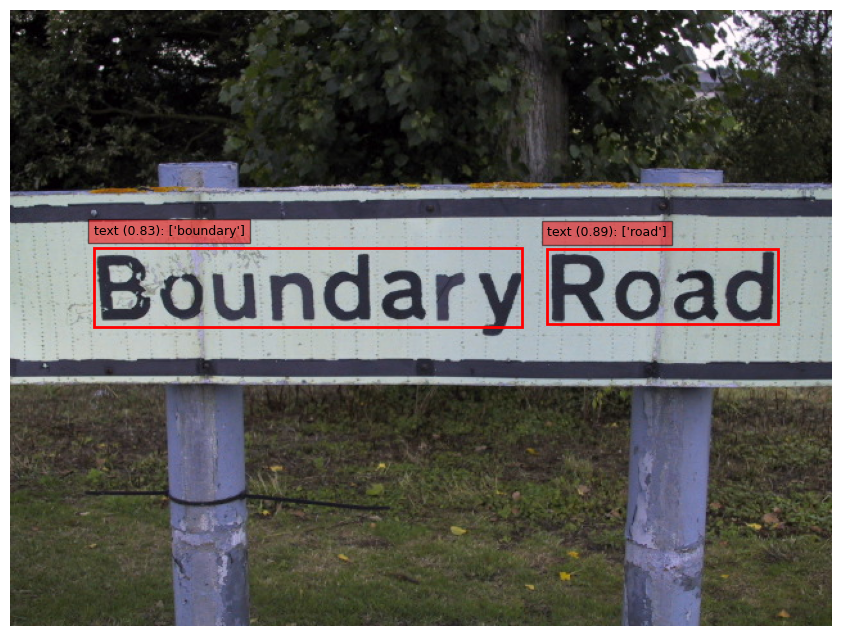

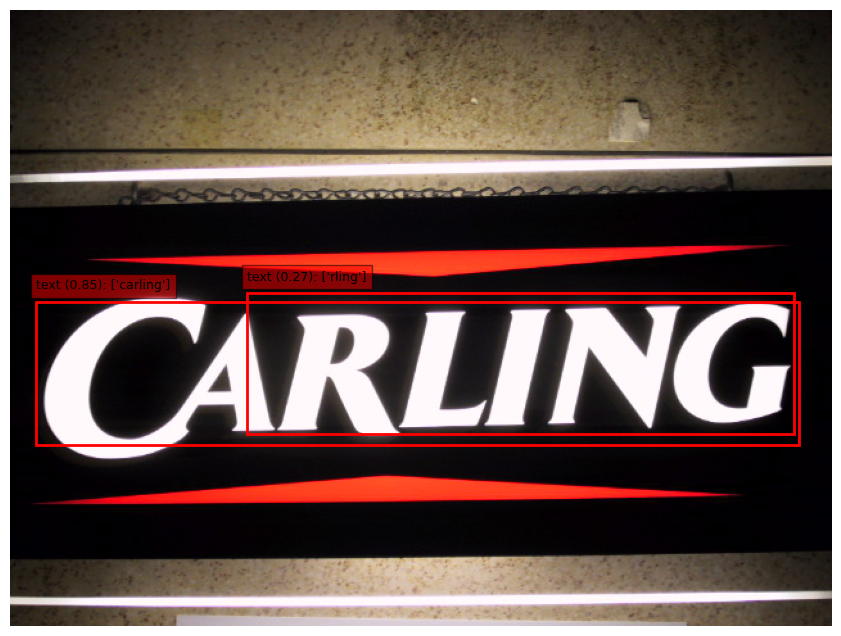

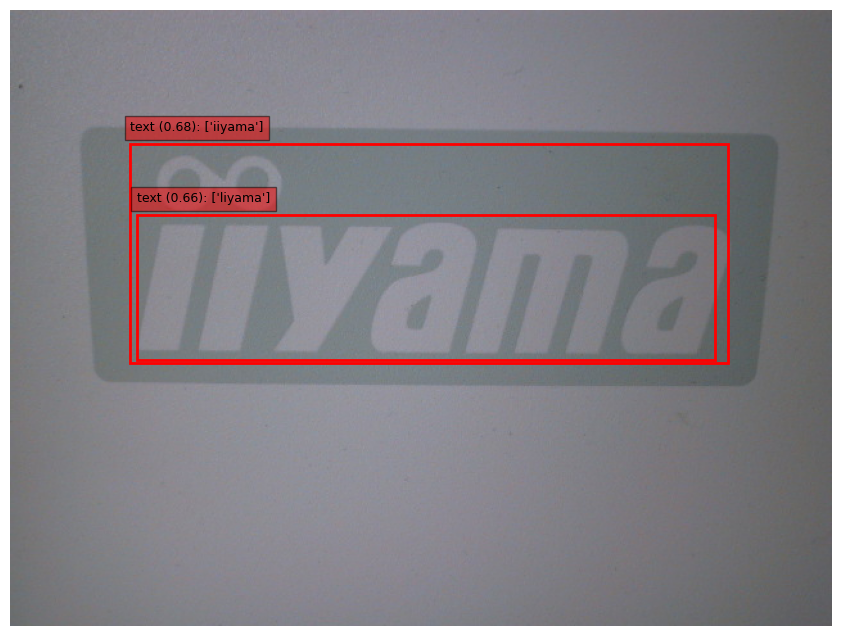

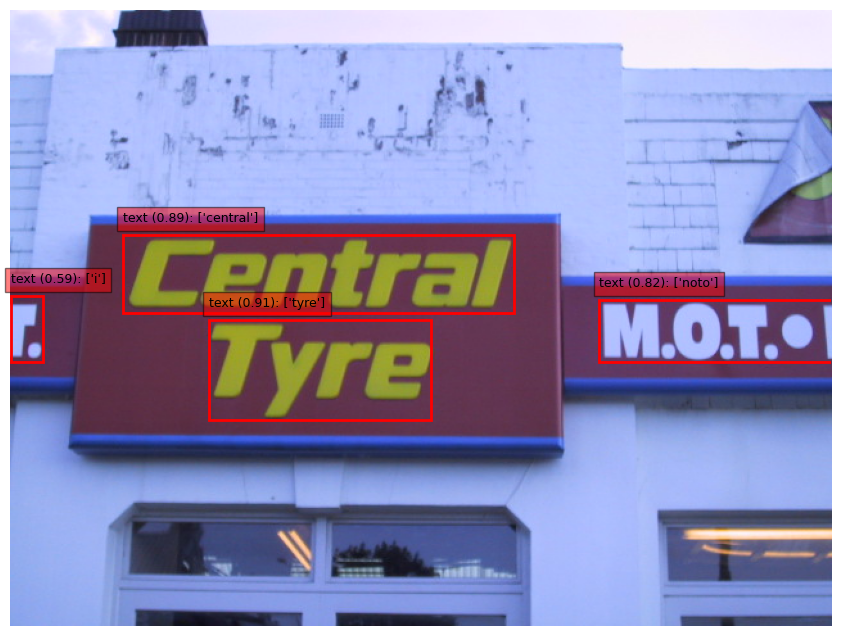

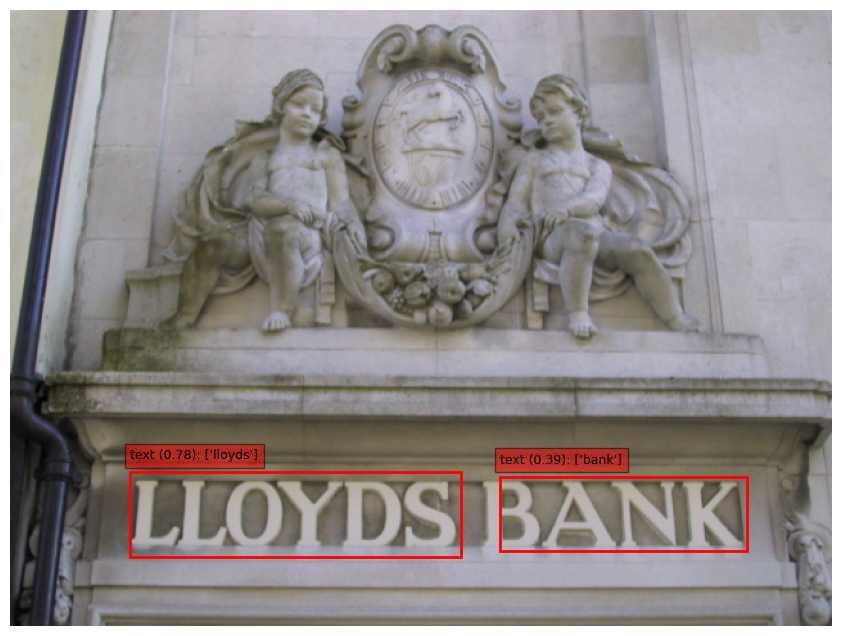

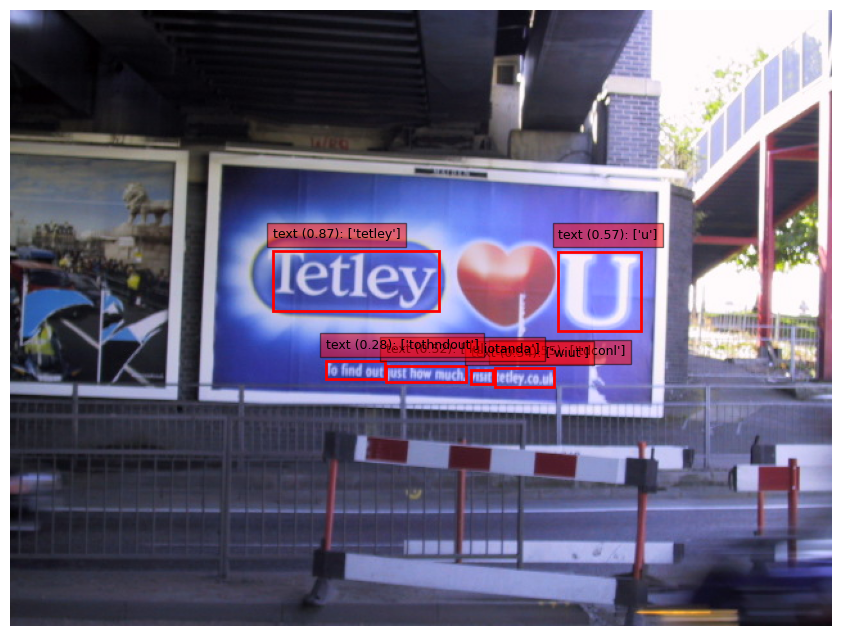

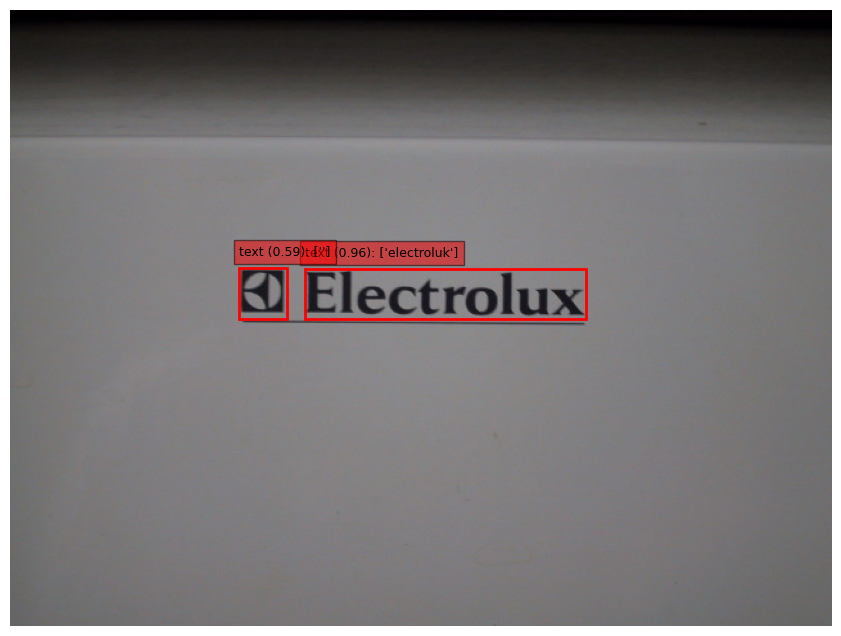

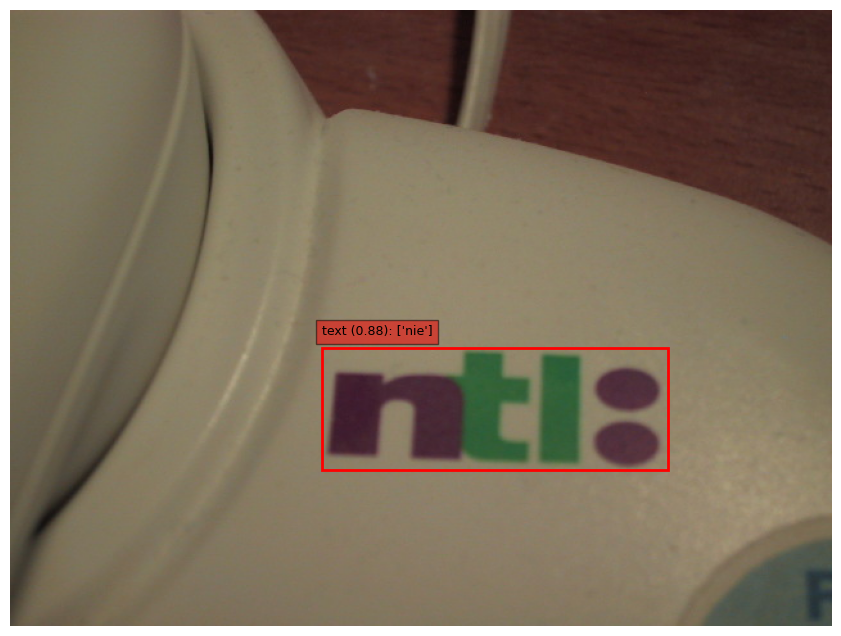

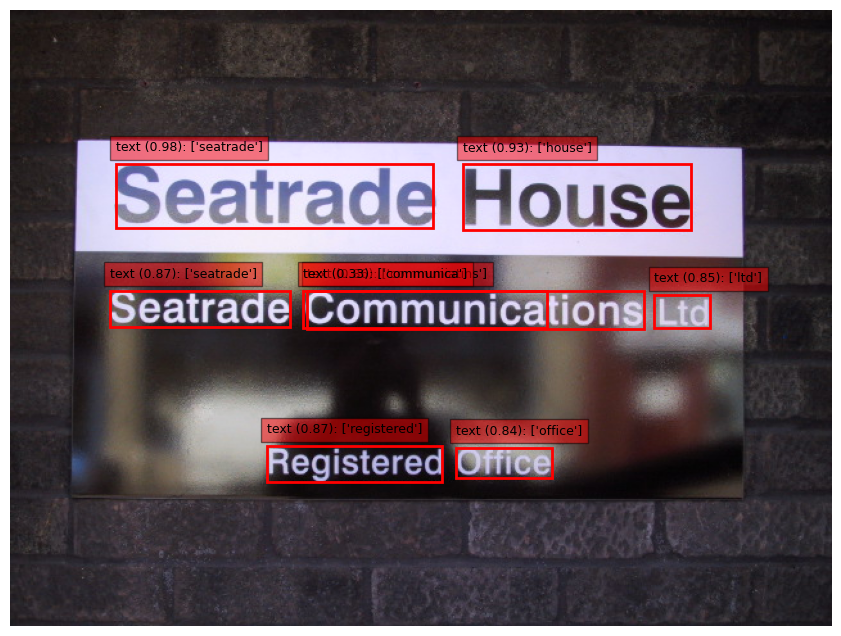

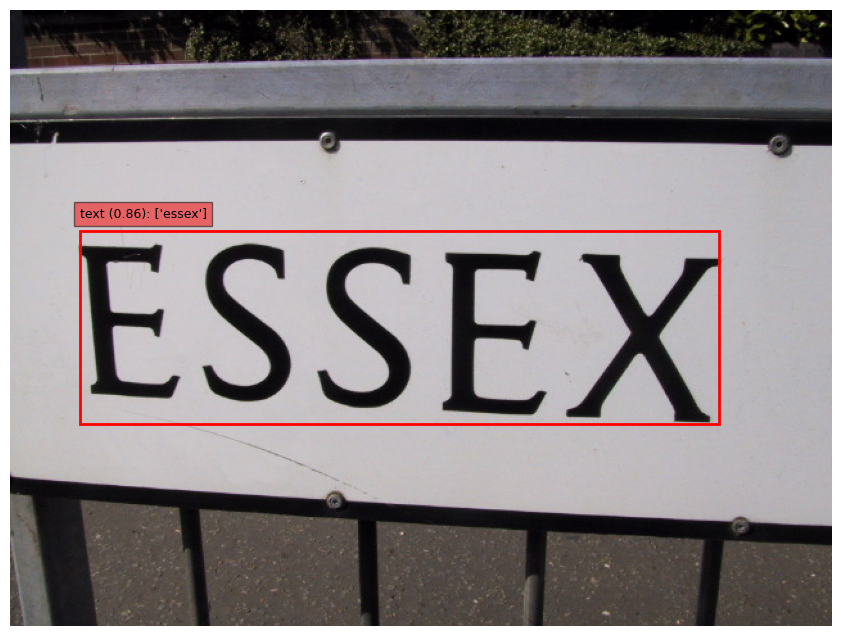

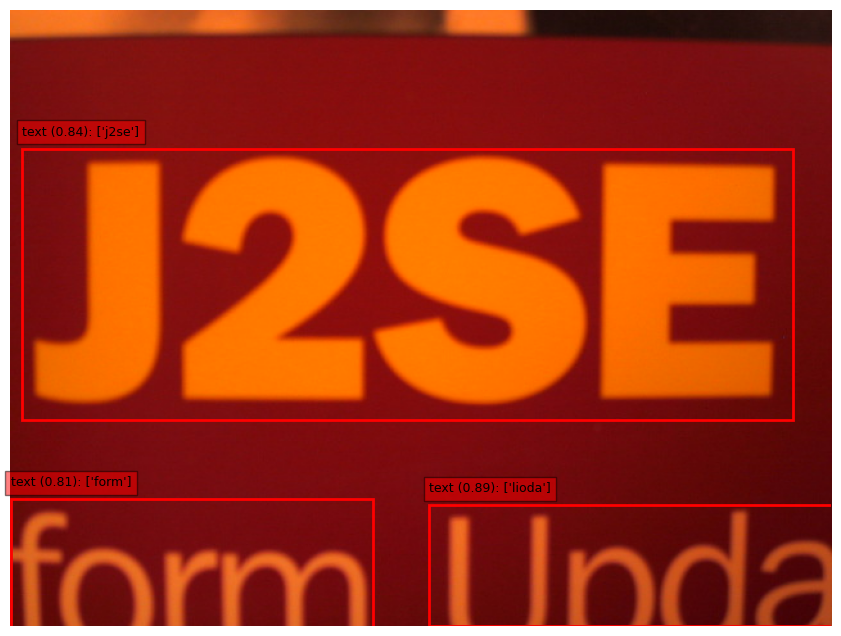

In [21]:
img_dir = "scene-text/lfsosa_12.08.2002"
inf_transforms = data_transforms["val"]

for idx, img_filename in enumerate(os.listdir(img_dir)):
    img_path = os.path.join(img_dir, img_filename)
    predictions = predict(
        img_path,
        data_transforms=inf_transforms,
        detection_model=yolo,
        recognition_model=crnn_model,
        idx_to_char=idx_to_char,
        device=device,
    )

    if idx == 10:
        break